In [71]:
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras.layers import TimeDistributed
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import numpy as np
import itertools
import glob
import os
import json
import sys
import time
import math

In [72]:
asanas = {0:'bhujangasan', 1:'padamasan', 2:'shavasan', 3:'tadasan', 4:'trikonasan', 5:'vrikshasan'}

In [73]:
def calculate_angle(a, b, c):
    a = np.array(a)  # First
    b = np.array(b)  # Mid
    c = np.array(c)  # End

    radians= np.arctan2(c[1]-b[1],  c[0]-b[0])- np.arctan2(a[1]-b[1],  a[0]-b[0])
    angle = np.abs(radians*180/np.pi)

    if(angle>180):
        angle=360-angle
    
    return angle
    
def calculate_len(a,b):
    a = np.array(a)  # First point
    b = np.array(b)  # Last point
    r_sq = (a[0]-b[0])**2 + (a[1]-b[1])**2
    if(len(a)==3):
        r_sq = r_sq+(a[2]-b[2])**2
    r=math.sqrt(r_sq)
    return r

In [74]:
def calculate_angles_landmark(detecting_pose_landmark,count):
    
    left_shoulder = detecting_pose_landmark[count][11]
    left_hip = detecting_pose_landmark[count][23]
    right_shoulder = detecting_pose_landmark[count][12]
    right_hip = detecting_pose_landmark[count][24]
    left_elbow = detecting_pose_landmark[count][13]
    left_knee = detecting_pose_landmark[count][25]
    right_elbow = detecting_pose_landmark[count][14]
    right_knee = detecting_pose_landmark[count][26]
    left_wrist = detecting_pose_landmark[count][15]
    left_ankle = detecting_pose_landmark[count][27]
    right_wrist = detecting_pose_landmark[count][16]
    right_ankle = detecting_pose_landmark[count][28]

    left_shoulder_angle = calculate_angle(left_hip, left_shoulder, left_elbow)
    right_shoulder_angle = calculate_angle(right_hip, right_shoulder, right_elbow)
    left_elbow_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)
    right_elbow_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
    left_hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
    right_hip_angle = calculate_angle(right_shoulder, right_hip, right_knee)
    left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
    right_knee_angle = calculate_angle(right_hip, right_knee, left_ankle)

    display_angles = [[left_shoulder_angle, 11], [right_shoulder_angle, 12], [left_elbow_angle, 13], [right_elbow_angle, 14], 
    [left_hip_angle, 23], [right_hip_angle, 24], [left_knee_angle, 25], [right_knee_angle, 26]]
    return display_angles

In [75]:
def calculate_angles_landmark_photo(detecting_pose_landmark):
    left_shoulder =  (detecting_pose_landmark[0][11])
    left_hip =  (detecting_pose_landmark[0][23])
    right_shoulder =  (detecting_pose_landmark[0][12])
    right_hip =  (detecting_pose_landmark[0][24])
    left_elbow =  (detecting_pose_landmark[0][13])
    left_knee =  (detecting_pose_landmark[0][25])
    right_elbow =  (detecting_pose_landmark[0][14])
    right_knee =  (detecting_pose_landmark[0][26])
    left_wrist =  (detecting_pose_landmark[0][15])
    left_ankle =  (detecting_pose_landmark[0][27])
    right_wrist =  (detecting_pose_landmark[0][16])
    right_ankle =  (detecting_pose_landmark[0][28])

    left_shoulder_angle = calculate_angle(left_hip, left_shoulder, left_elbow)
    right_shoulder_angle = calculate_angle(right_hip, right_shoulder, right_elbow)
    left_elbow_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)
    right_elbow_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
    left_hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
    right_hip_angle = calculate_angle(right_shoulder, right_hip, right_knee)
    left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
    right_knee_angle = calculate_angle(right_hip, right_knee, left_ankle)

    display_angles = [[left_shoulder_angle, 11], [right_shoulder_angle, 12], [left_elbow_angle, 13], [right_elbow_angle, 14], 
    [left_hip_angle, 23], [right_hip_angle, 24], [left_knee_angle, 25], [right_knee_angle, 26]]
    return display_angles

In [76]:
def addToPred(Xch,count,Xarr, seq, m, correct_file):
    Xarr[count] = Xch[m]
    count = count + 1
    m=m+1
    if count == 3:
        Xtch = Xarr
        # print(Xtch.shape[0])
        Xarr = np.empty((3,33,2))
        count = 0
        seq  = seq + 1
        X = np.asarray(correct_file)
        X1 =  X[:,:,0]
        X2 = X[:,:,1]
        Xch = np.dstack((X1,X2))
        # print(Xch)
        # Xch = np.asarray(correct_file)
        
        correct_angles = calculate_angles_landmark_photo(Xch)
        rounded_angles = [(round(angle), joint_index) for angle, joint_index in correct_angles]
        # print(rounded_angles)        
        
        ideal_angles = {11: rounded_angles[0][0] , 12: rounded_angles[1][0], 13: rounded_angles[2][0], 14: rounded_angles[3][0], 23: rounded_angles[4][0], 24: rounded_angles[5][0], 25: rounded_angles[6][0], 26: rounded_angles[7][0]}
        joint_angle_name = {11: "left_shoulder", 12: "right_shoulder", 13: "left_elbow", 14: "right_elbow", 23: "left_hip", 24: "right_hip", 25: "left_knee", 26: "right_knee"}
        angle_tolerance = 3  # Tolerance for angle difference
        noft= Xtch.shape[0]

        avg_test_angles = {11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0}
        
        for i in range(noft):
            # print(i)
            test_angles = calculate_angles_landmark(Xtch, i)
            # print(test_angles)
            test_angle_dict = {joint_index: angle for angle, joint_index in test_angles}        
            # print(test_angle_dict)
            for key in test_angle_dict:
                if key in avg_test_angles:
                    avg_test_angles[key] += test_angle_dict[key]
        
        divisor = noft       
        avg_test_angles = {key: value / divisor for key, value in avg_test_angles.items()}        
        rounded_angles = [(round(value), key) for key, value in avg_test_angles.items()]      
        print("Frame", m)
        feedback = {}

        for angle, joint_index in rounded_angles:
            if joint_index in ideal_angles:
                correct_angle = ideal_angles[joint_index]
                if correct_angle - angle_tolerance <= angle <= correct_angle + angle_tolerance:
                    feedback[joint_index] = joint_angle_name[joint_index] + " - correct angle"

                else:
                    required_rotation = correct_angle - angle
                    feedback[joint_index] = joint_angle_name[joint_index] + " - incorrect angle. Rotate {} degrees for {}. ".format(abs(required_rotation), joint_angle_name[joint_index])

            else:
                feedback[joint_index] = "Joint not found in correct angles"

        print("Feedback for Frame", m, ":\n")

        for value in feedback.values():
            print(value + "\n")
    
    return (seq, count , Xarr,m)

In [77]:
def giveFeedback(test_video_file,count,Xarr,seq,m, correct_file):
    with open(test_video_file) as json_data:
            d = json.load(json_data)    
            X = np.asarray(d)
            X1 =  X[:,:,0]
            X2 = X[:,:,1]
            Xch_cif = np.dstack((X1,X2))
            nof= Xch_cif.shape[0]
            seq ,count, Xarr,m = addToPred(Xch_cif,count,Xarr,seq,m, correct_file)
            json_data.close
        #     print('4')
    return (seq, count, Xarr,m, nof)

In [78]:
def save_intermediate(correct_intermediate_json_data, test_video, i, present_frame, final_best_frame_number):
    with open(test_video) as json_data:
        d = json.load(json_data)    
        X = np.asarray(d)
        X1 =  X[:,:,0]
        X2 = X[:,:,1]
        Xch = np.dstack((X1,X2))
        nof= Xch.shape[0]
        
        final_frame = final_best_frame_number
        if final_frame==0:
            final_frame= nof
        
        print(final_frame)

    # with open(inter_correct, 'r') as f:
        # data = json.load(f)
        X = np.asarray(correct_intermediate_json_data[i])
        X1 =  X[:,:,0]
        X2 = X[:,:,1]
        Xinter = np.dstack((X1,X2))

        correct_angles = calculate_angles_landmark_photo(Xinter)   

        best_inter_match = []
        min_variance = float('inf')
        best_frame = -1

        for j in range(present_frame, final_frame):
            test_angles = calculate_angles_landmark(Xch, j)
            diff = np.abs(np.array(correct_angles) - np.array(test_angles)).mean()
            variance = diff

            if variance < min_variance:
                min_variance = variance
                # print('min_variance',min_variance)
                best_frame = j
                best_inter_match = d[i]
        
        # print(min_variance)

        if min_variance<10:
            print(f"The frame with the closest angles is frame {best_frame}")
        else:
            print(f'intermediate step {i} is skipped')

        
        remainder = best_frame % 3
        if remainder == 0:
            best_frame = best_frame
        elif remainder == 1:
            best_frame = best_frame - 1
        else:  # remainder == 2
            best_frame = best_frame + 1
    
    # print(best_inter_match)
    return best_inter_match, best_frame

In [79]:
import glob
import json
import os

# Replace with your folder path and input word
folder_path = "/home/nishita/UGP_Nishita/Feedback generation/Correct_intermediate_poses"
input_word = "Dhanuarasana_json"

# Find the folder that matches the input word
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
selected_folder = next((folder for folder in subfolders if input_word in folder), None)

if selected_folder is None:
    print(f"No folder found for input word: {input_word}")
else:
    # Find all JSON files in the selected folder
    json_files = glob.glob(os.path.join(selected_folder, "*.json"))
    # Sort the file paths based on the numeric part of their names
    json_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))

    # Load the JSON data into a list
    json_data = []
    for json_file in json_files:
        print('json_file', json_file)
        with open(json_file, 'r') as f:
            json_data.append(json.load(f))

    # Now json_data is a list of JSON data from all files in the selected folder
save_json_data_correct_intermediate_frames = json_data
# print('json_data',json_data[2])

json_file /home/nishita/UGP_Nishita/Feedback generation/Correct_intermediate_poses/Dhanuarasana_json/Dhanuarasana_intermediate_1.json
json_file /home/nishita/UGP_Nishita/Feedback generation/Correct_intermediate_poses/Dhanuarasana_json/Dhanuarasana_intermediate_2.json
json_file /home/nishita/UGP_Nishita/Feedback generation/Correct_intermediate_poses/Dhanuarasana_json/Dhanuarasana_intermediate_3.json
json_file /home/nishita/UGP_Nishita/Feedback generation/Correct_intermediate_poses/Dhanuarasana_json/Dhanuarasana_intermediate_4.json


In [80]:
import glob
import os
import cv2

count = 0
seq = 0
Xarr = np.empty((3,33,2))
lastRead = "none"
m=0

# Get the file
test_video= '/home/nishita/UGP_Nishita/Feedback generation/Test_videos/Dhanurasana/Test_video_Dhanuarasana_1.mp4'
list_of_files = glob.glob("/home/nishita/UGP_Nishita/Feedback generation/Test_videos/Dhanurasana_json/Test_video_Dhanuarasana_1.json")
latest_file = max(list_of_files, key=os.path.getctime)

cap = cv2.VideoCapture(test_video)
intermediate_collection = []

present_frame = 0
best_index = []

#json data is data the data of intermediate poses
print(len(json_files))

final_best_frame, final_best_frame_number = save_intermediate(json_data, latest_file, len(json_files)-1, present_frame,0)
print(final_best_frame_number)

present_frame = 0

for i in range(len(json_files)):
    intermediate, best = save_intermediate(json_data, latest_file, i, present_frame, final_best_frame_number)
    present_frame = best
    intermediate_collection.append(intermediate)
    best_index.append(best) # Append the intermediate to a list

print(best_index)

4
793
The frame with the closest angles is frame 493
492
492
intermediate step 0 is skipped
492
The frame with the closest angles is frame 357
492
The frame with the closest angles is frame 453
492
The frame with the closest angles is frame 491
[183, 357, 453, 492]


In [81]:
import cv2
import json
import os

# Function to save frame as image
def save_frame_as_image(frame,i, frame_number, output_directory):
    image_path = os.path.join(output_directory, f"Dhanuar_best_intermediate_{i+1}_{frame_number}.jpg")
    cv2.imwrite(image_path, frame)
    print(f"Saved frame {frame_number} as {image_path}")

# Load your JSON data and corresponding frame numbers
json_data_list = [...]  # Your list of JSON data
frame_numbers = [...]   # Your list of corresponding frame numbers

# Load video file
video_path = '/home/nishita/UGP_Nishita/Feedback generation/Test_videos/Dhanurasana/Test_video_Dhanuarasana_1.mp4'
cap = cv2.VideoCapture(video_path)

# Output directory for saving images
output_directory = '/home/nishita/UGP_Nishita/Feedback generation/Best_intermediate_poses'
os.makedirs(output_directory, exist_ok=True)

i=0
# Iterate over each JSON data and corresponding frame number
for json_data, frame_number in zip(intermediate_collection, best_index):
    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()
    if ret:
        # Save the frame as image
        save_frame_as_image(frame,i, frame_number, output_directory)
        i=i+1
    else:
        print(f"Error reading frame {frame_number}")

# Release the video capture object
cap.release()


Saved frame 183 as /home/nishita/UGP_Nishita/Feedback generation/Best_intermediate_poses/Dhanuar_best_intermediate_1_183.jpg
Saved frame 357 as /home/nishita/UGP_Nishita/Feedback generation/Best_intermediate_poses/Dhanuar_best_intermediate_2_357.jpg
Saved frame 453 as /home/nishita/UGP_Nishita/Feedback generation/Best_intermediate_poses/Dhanuar_best_intermediate_3_453.jpg
Saved frame 492 as /home/nishita/UGP_Nishita/Feedback generation/Best_intermediate_poses/Dhanuar_best_intermediate_4_492.jpg


In [82]:
print(best_index)

[183, 357, 453, 492]


In [83]:
json_data = save_json_data_correct_intermediate_frames
print(len(json_data))
correct_file = json_data[0]
print(correct_file)
count = 0
seq= 0
print(latest_file)

while True:
    if lastRead != latest_file:
        try:
            seq, count, Xarr, m, nof = giveFeedback(latest_file, count, Xarr, seq, m, correct_file)

        except:
            print("Frame issue")

        # Switch to correct_file_2 once m reaches best
        if m==best_index[-1]:
            print('video is completed')
            break

        if m in best_index:
            print('person has achieved intermediate state:', count+1)
            count = count+ 1
            print("Switching to next_pose")
            if count<len(json_data):
                correct_file = json_data[count]
                count=0
       
    if m == nof:
        break

4
[[[0.6653366088867188, 0.6601358652114868], [0.6680054664611816, 0.647628903388977], [0.6676316261291504, 0.6456644535064697], [0.6673433780670166, 0.643523097038269], [0.6676044464111328, 0.6488949656486511], [0.666948676109314, 0.6479026675224304], [0.6663647890090942, 0.6468111276626587], [0.659423291683197, 0.6304427981376648], [0.6584601998329163, 0.6361859440803528], [0.6578923463821411, 0.6597130298614502], [0.6572853922843933, 0.6616692543029785], [0.6083442568778992, 0.6154034733772278], [0.6112751364707947, 0.650497317314148], [0.5337910652160645, 0.6100001931190491], [0.5354561805725098, 0.6535394191741943], [0.4776526689529419, 0.6276514530181885], [0.4673812687397003, 0.6735404133796692], [0.4609328806400299, 0.6265775561332703], [0.4492989778518677, 0.6760604977607727], [0.45859962701797485, 0.6427428722381592], [0.4474099278450012, 0.6773087382316589], [0.4645719826221466, 0.6430270075798035], [0.4537413716316223, 0.6749112606048584], [0.4860500395298004, 0.61484932899

<Figure size 300x300 with 0 Axes>

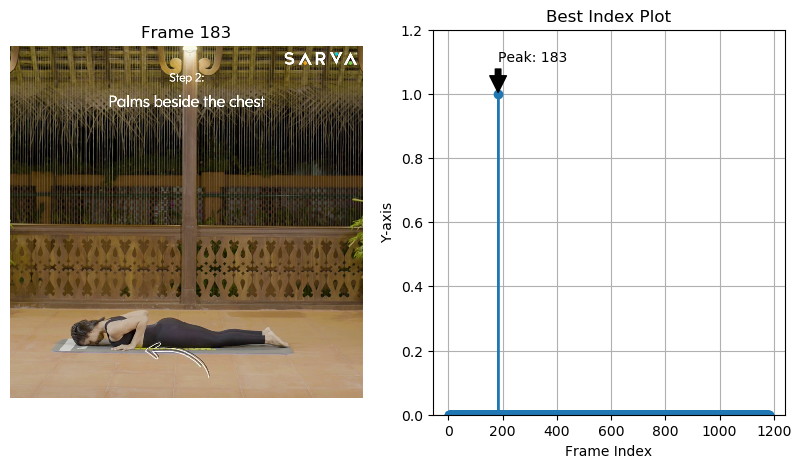

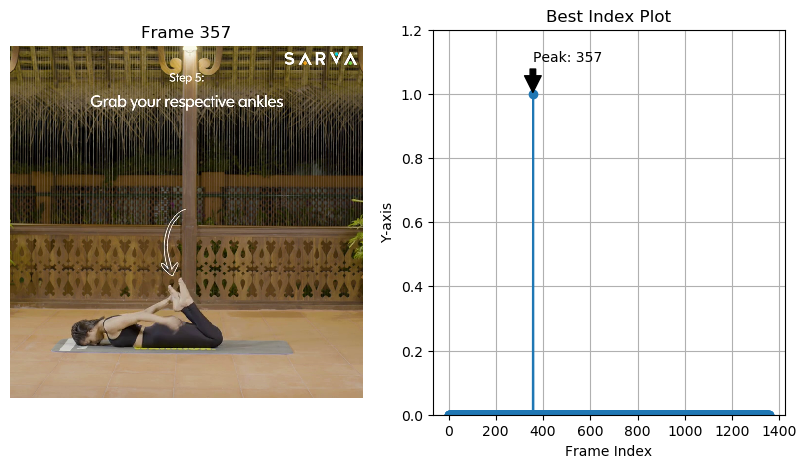

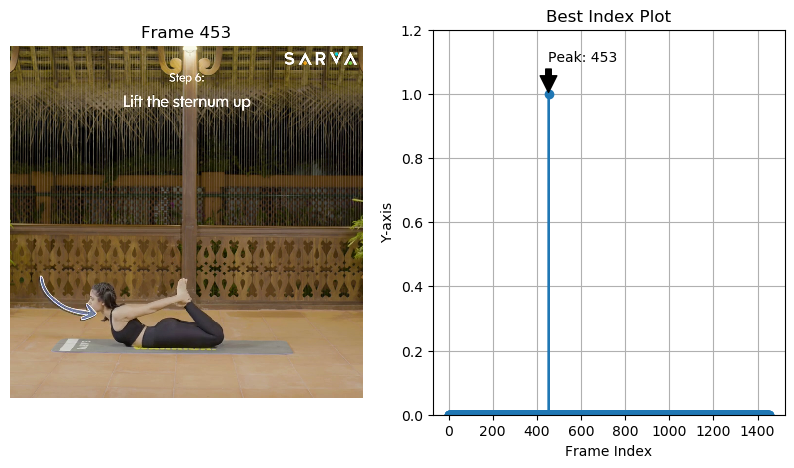

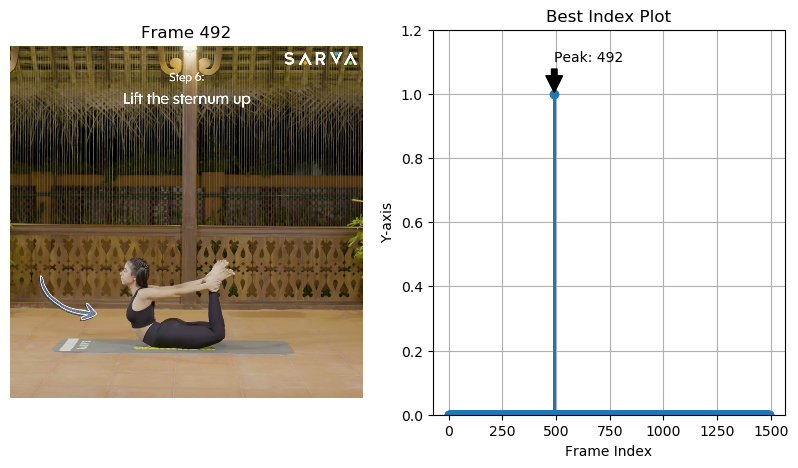

In [84]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load your video
video_path = test_video
cap = cv2.VideoCapture(video_path)

# Set the size of the plot
plt.figure(figsize=(3, 3))  # Adjust width and height as needed

# Iterate through each frame of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Get the current frame number
    frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    
    # Check if the current frame number is in best_index
    if frame_number in best_index:
        
        # Set the x-axis range based on the maximum index
        x_values = np.arange(1, frame_number + 1000)  # Adding 1000 to ensure space for last peak
        
        # Define the y values
        y_values = np.zeros_like(x_values)
        idx = frame_number
        if idx < len(x_values):
            y_values[idx] = 1
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
        # Display the frame using Matplotlib
        # Plot the image in the first subplot (ax1)
        ax1.imshow(frame_rgb)
        ax1.set_title(f'Frame {frame_number}')
        ax1.axis('off')  # Turn off the axis

        
        ax2.plot(x_values, y_values, marker='o')
        
        # Annotate the peak index on the plot
        ax2.annotate(f'Peak: {frame_number}', xy=(frame_number, 1), xytext=(frame_number, 1.1),
                     arrowprops=dict(facecolor='black', shrink=0.05))
        
        # Set labels and title for the plot
        ax2.set_xlabel('Frame Index')
        ax2.set_ylabel('Y-axis')
        ax2.set_ylim(0, 1.2)
        ax2.set_title('Best Index Plot')
        ax2.grid(True)  # Enable grid for clarity
        
        # Show the figure
        plt.show()  # This will display the image and plot side by side
        
        # Pause for a moment to allow time for the figure to display
        plt.pause(0.01)
        
    # Display the video frame
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
